In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from utils import EnhancerDataset, split_dataset, train_model, regression_model_plot,EnhancerDatasetWithID
import pandas as pd
from tqdm import tqdm
import glob
import torch.nn as nn
import torch.nn.modules.activation as activation
import sys
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import interpretation
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../model')  
from model import ConvNetDeep, DanQ, ExplaiNN,ConvNetDeep2, ExplaiNN2, ExplaiNN3,DeepSTARR


In [1]:
import os
import pandas as pd
import numpy as np

# Define the directory containing all subdirectories with CSV files
base_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred'

# Initialize lists to store combined data for each file type
gfp_plus_non_annotated_data = []
gfp_minus_non_annotated_data = []
gfp_plus_annotated_data = []
gfp_minus_annotated_data = []

# Iterate through each subdirectory
for sub_dir in os.listdir(base_dir):
    sub_dir_path = os.path.join(base_dir, sub_dir)
    
    # Check if it's a directory and follows the expected naming format
    if os.path.isdir(sub_dir_path) and sub_dir.startswith('CNN') and '_Seed' in sub_dir:
        # Extract CNN and Seed values from the directory name
        parts = sub_dir.split('_')
        cnn_number = parts[0].replace('CNN', '')
        seed_number = parts[1].replace('Seed', '')
        
        # Define paths for the GFP+ and GFP- CSV files
        gfp_plus_path = os.path.join(sub_dir_path, 'GFP+_sorted_tf_order.csv')
        gfp_minus_path = os.path.join(sub_dir_path, 'GFP-_sorted_tf_order.csv')
        
        # Define a function to process each file
        def process_file(file_path, data_list, annotated_data_list, cnn, seed):
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                
                # Sort by absolute importance score in descending order
                df = df.reindex(df['importance_score'].abs().sort_values(ascending=False).index)

                # Select top 10 motifs for non-annotated data
                non_annotated_top10 = df.iloc[:10] if len(df) >= 10 else df
                non_annotated_row = [cnn, seed] + non_annotated_top10['tf_name'].tolist() + non_annotated_top10['importance_score'].tolist()
                # Pad with blanks if fewer than 10 motifs
                non_annotated_row += [''] * (20 - len(non_annotated_row[2:]))
                data_list.append(non_annotated_row)

                # Select motifs with '-' character in 'tf_name'
                annotated_df = df[df['tf_name'].str.contains('-')]
                
                # Select top 10 annotated motifs by absolute importance score
                annotated_top10 = annotated_df.iloc[:10] if len(annotated_df) >= 10 else annotated_df
                annotated_row = [cnn, seed] + annotated_top10['tf_name'].tolist() + annotated_top10['importance_score'].tolist()
                # Pad with blanks if fewer than 10 annotated motifs
                annotated_row += [''] * (20 - len(annotated_row[2:]))
                annotated_data_list.append(annotated_row)

        # Process GFP+ and GFP- files for non-annotated and annotated data
        process_file(gfp_plus_path, gfp_plus_non_annotated_data, gfp_plus_annotated_data, cnn_number, seed_number)
        process_file(gfp_minus_path, gfp_minus_non_annotated_data, gfp_minus_annotated_data, cnn_number, seed_number)

# Define column names
tf_columns = [f'tf{i+1}' for i in range(10)]
score_columns = [f'score{i+1}' for i in range(10)]
columns = ['CNN', 'Seed'] + tf_columns + score_columns

# Create DataFrames for each file type
gfp_plus_non_annotated_df = pd.DataFrame(gfp_plus_non_annotated_data, columns=columns)
gfp_minus_non_annotated_df = pd.DataFrame(gfp_minus_non_annotated_data, columns=columns)
gfp_plus_annotated_df = pd.DataFrame(gfp_plus_annotated_data, columns=columns)
gfp_minus_annotated_df = pd.DataFrame(gfp_minus_annotated_data, columns=columns)

# Save the DataFrames to CSV files
output_dir = base_dir
gfp_plus_non_annotated_df.to_csv(os.path.join(output_dir, 'non_annotated_GFP+_combined.csv'), index=False)
gfp_minus_non_annotated_df.to_csv(os.path.join(output_dir, 'non_annotated_GFP-_combined.csv'), index=False)
gfp_plus_annotated_df.to_csv(os.path.join(output_dir, 'annotated_GFP+_combined.csv'), index=False)
gfp_minus_annotated_df.to_csv(os.path.join(output_dir, 'annotated_GFP-_combined.csv'), index=False)

print("Combined files saved as non_annotated_GFP+_combined.csv, non_annotated_GFP-_combined.csv, annotated_GFP+_combined.csv, and annotated_GFP-_combined.csv.")


Combined files saved as non_annotated_GFP+_combined.csv, non_annotated_GFP-_combined.csv, annotated_GFP+_combined.csv, and annotated_GFP-_combined.csv.


# GFP

In [2]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN3_GFP/combined_file.csv')
cnns = list(set(params['num_cnns']))

In [ ]:
temp_df = params[params['num_cnns'] == 10]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

num_cnns = 10
target_labels = ["GFP"]
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_10NN'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

cnn: 10
lr: 0.0001    drop_out: 0.3
batch: 168    seed: 566


## Train

In [ ]:
seed = int(best_seed)
batch = int(best_batch)
learning_rate= best_lr
#target_labels = ["GFP"]
#output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_10NN'

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_input_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=['GFP'], scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=['GFP'], scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=['GFP'], scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 1, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader,test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/60, Loss: 0.2353
Epoch 1/200 -- Train Loss: 0.1915 , Validation Loss: 0.1192
------------------------Evaluation------------------------
Label 1: MSE=0.1195, RMSE=0.3457, MAE=0.2729, R^2=-0.5775, Pearson=0.3276, Spearman=0.3188
Overall (Flattened): MSE=0.1195, RMSE=0.3457, MAE=0.2729, R^2=-0.5775, Pearson=0.3276, Spearman=0.3188
----------------------------------------------------------
Epoch 2/200, Step 1/60, Loss: 0.1857
Epoch 2/200 -- Train Loss: 0.1456 , Validation Loss: 0.1047
------------------------Evaluation------------------------
Label 1: MSE=0.1050, RMSE=0.3240, MAE=0.2554, R^2=-0.3854, Pearson=0.4050, Spearman=0.3936
Overall (Flattened): MSE=0.1050, RMSE=0.3240, MAE=0.2554, R^2=-0.3854, Pearson=0.4050, Spearman=0.3936
----------------------------------------------------------
Epoch 3/200, Step 1/60, Loss: 0.1244
Epoch 3/200 -- Train Loss: 0.1227 , Validation Loss: 0.0882
------------------------Evaluation-----

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

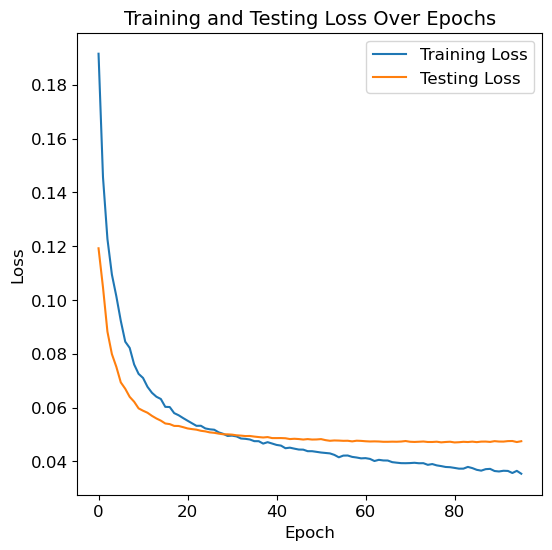

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

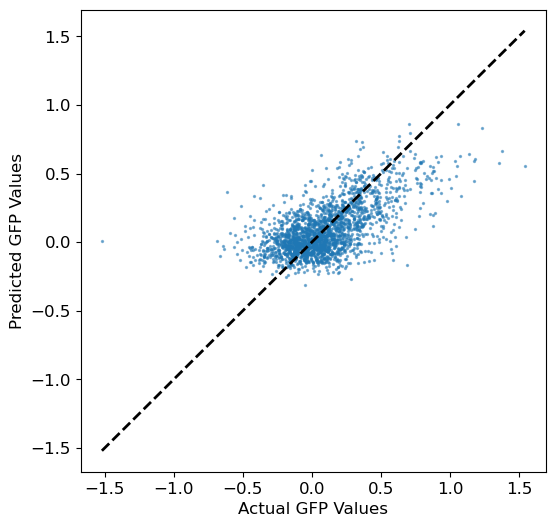

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

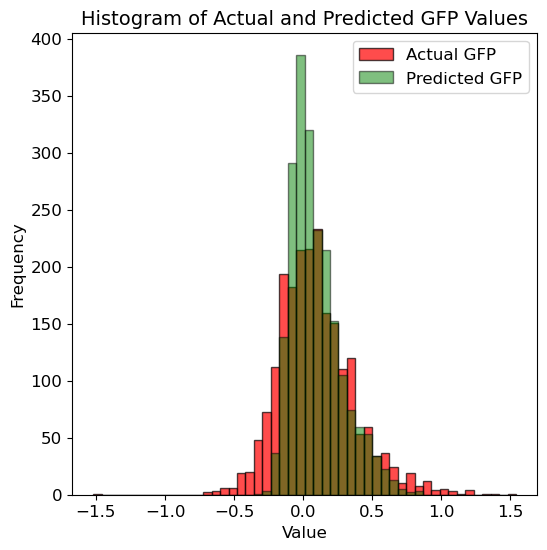

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

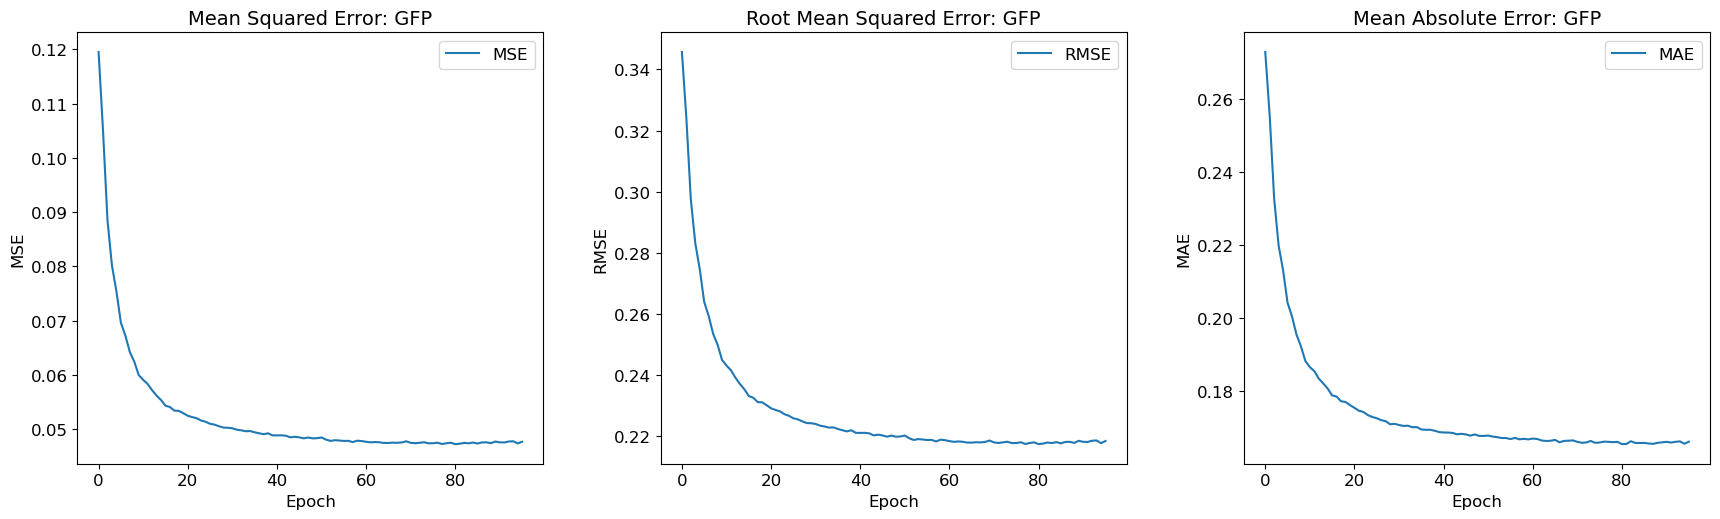

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

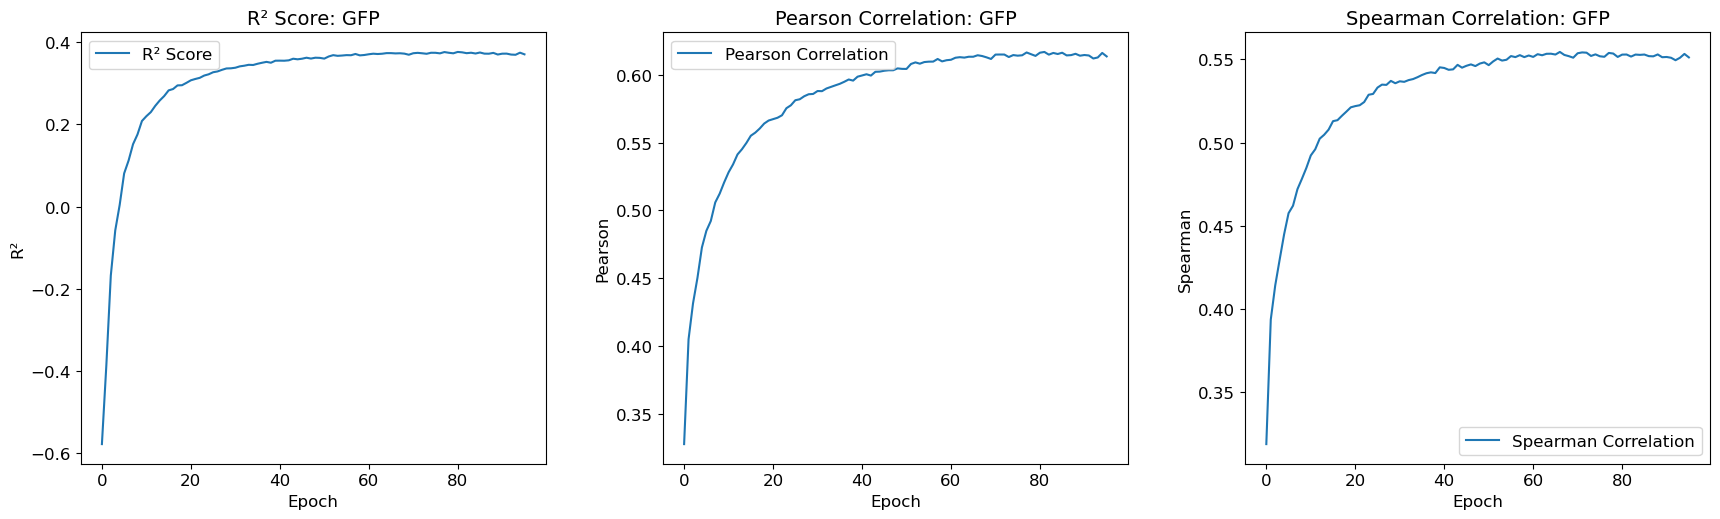

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

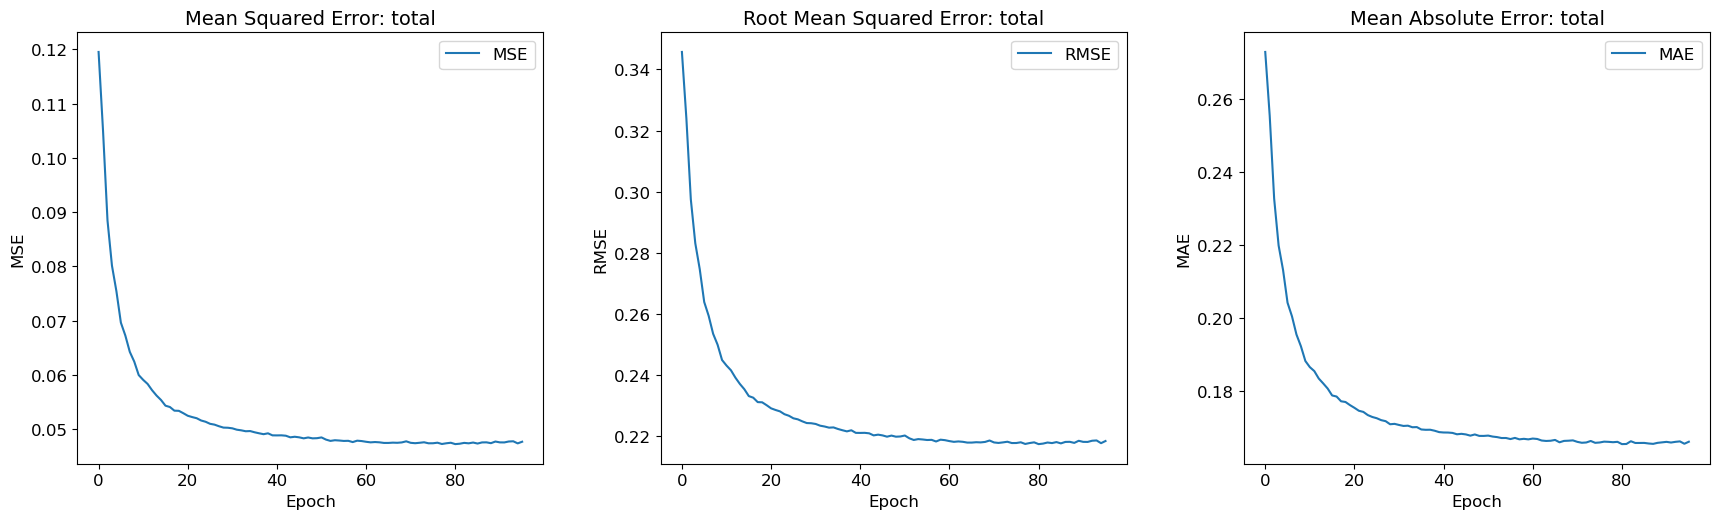

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

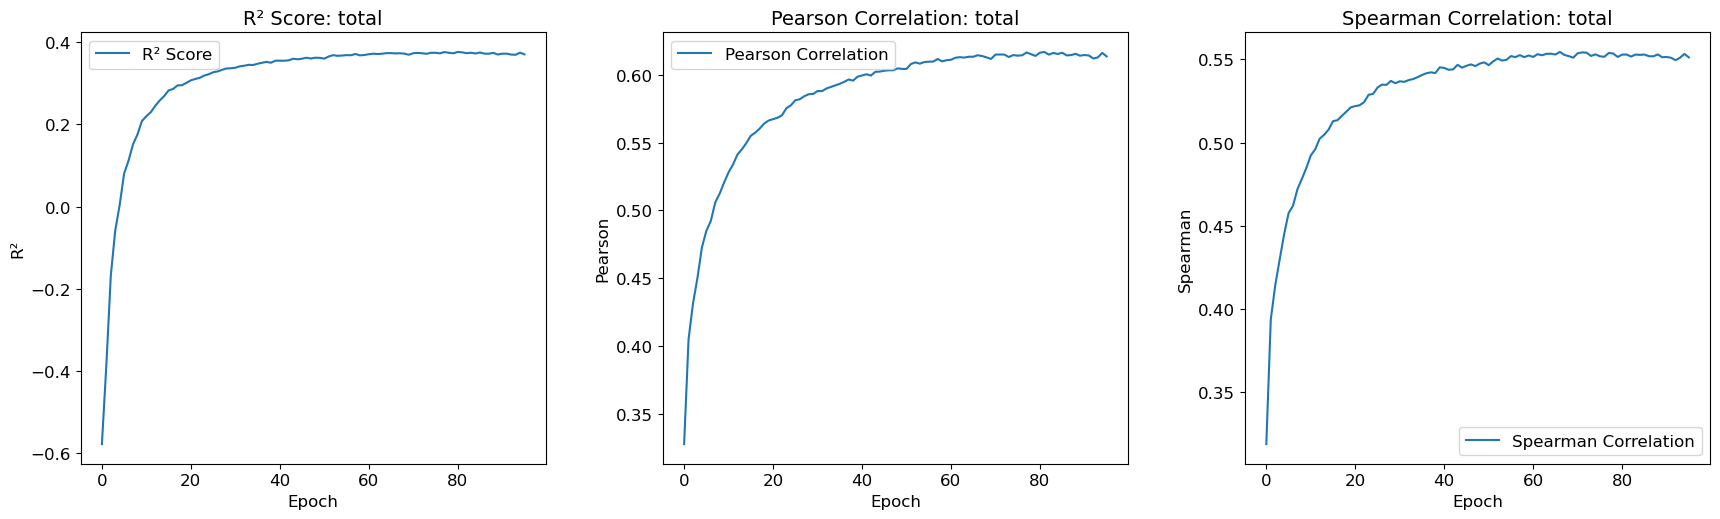

MSE: 0.0477, RMSE: 0.2184, MAE: 0.1662
R^2: 0.3705, Pearson Correlation: 0.6135, Spearman Correlation: 0.5512


In [10]:
model_path = glob.glob(f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_10NN/best_pearson*.pth')[0]

mse, rmse, mae, r2, pearson_corr, spearman_corr = regression_model_plot(
    model, test_loader, train_losses_by_batch, test_losses_by_batch, 
    device, results, target_labels, save_plot = False, dir_path = None, model_path = model_path)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}")

## Interpret

In [4]:
import subprocess
import json

command = [
    "python", "Interpret.py", 
    "--num_class", "1", 
    "--seed", str(best_seed), 
    "--batch", str(best_batch), 
    "--num_cnns", str(num_cnns), 
    "--learning_rate", str(best_lr), 
    "--result_dir", output_dir,
    "--feature_list", json.dumps(['GFP']),  # Serialize list as JSON string
    "--target_labels", json.dumps(['GFP'])  # Serialize list as JSON string
]
#"--feature_list", json.dumps(['G+', 'G-']),  # Serialize list as JSON string
#"--target_labels", json.dumps(['GFP+', 'GFP-'])  # Serialize list as JSON string

# Run the command
result = subprocess.run(command, capture_output=True, text=True)

# Output the result
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)



STDOUT: Tomtom found at: /pmglocal/ty2514/meme/bin/tomtom
--------------------------------------------------------
***********************   1/8   ************************
--------------------------------------------------------
Attaching device to the gpu
Loading weight from following weight file to the model: 
['/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_10NN/best_pearson_model_epoch_81.pth']




--------------------------------------------------------
***********************   2/8   ************************
--------------------------------------------------------
Reading input data for retreiving predictions
Get prediction using trained model!
Prediction shape is (14301, 1)


--------------------------------------------------------
***********************   3/8   ************************
--------------------------------------------------------
Now selecting high confident predictions!
Using Bound = 0.25 as a cutoff to select high confident predictions.
Total number of inpu

In [5]:
filters = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_10NN/importance/GFP_sorted_tf_order.csv')
filters

tf_name  importance_score
0               f8          0.108850
1  AC0069(Pax4)-f0          0.078609
2               f4          0.074857
3  AC0069(Pax4)-f3          0.059937
4               f7          0.009458
5               f6         -0.012173
6               f9         -0.016902
7               f5         -0.019721
8               f1         -0.021056
9               f2         -0.052208

# G+ and G-

In [5]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN3_G+G-/ExplaiNN3_G+G-_Metrics.csv')
cnns = list(set(params['num_cnns']))

temp_df = params[params['num_cnns'] == 75]

group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
# Extract the learning rate, dropout rate, and batch number for this best group
best_lr = best_group['lr']
best_dropout = best_group['drop_out']
best_batch = best_group['batch']
# Filter the original DataFrame to keep only the rows matching the best group
best_group_df = temp_df[(temp_df['lr'] == best_lr) & 
                        (temp_df['drop_out'] == best_dropout) & 
                        (temp_df['batch'] == best_batch)]

# Find the row with the highest 'pearson_corr_p' within this filtered group
best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]

# Extract the seed with the highest 'pearson_corr_p' in the best group
best_seed = int(best_seed_row['seed'])
best_batch = int(best_batch)

num_cnns = 75
target_labels = ["GFP+","GFP-"]
feature_list = ["G+","G-"]
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred_70NN'

print(f'cnn: {num_cnns}')
print(f'lr: {best_lr}    drop_out: {best_dropout}')
print(f'batch: {best_batch}    seed: {best_seed}')

cnn: 75
lr: 0.0001    drop_out: 0.3
batch: 168    seed: 350


## Train

In [6]:
seed = best_seed
batch = best_batch
learning_rate= best_lr

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_input_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)

# Process datasets
train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode = 'none')
test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode = 'none')
validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)


input_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 2, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, peasron_metric, r2_metric, device  = train_model(input_model, train_loader, val_loader,test_loader, target_labels=target_labels,
                                                                                                                            num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path=output_dir)

Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/60, Loss: 68.8617
Epoch 1/200 -- Train Loss: 67.0997 , Validation Loss: 67.2020
------------------------Evaluation------------------------
Label 1: MSE=65.8747, RMSE=8.1163, MAE=8.1114, R^2=-1121.3764, Pearson=0.2095, Spearman=0.1876
Label 2: MSE=68.5359, RMSE=8.2786, MAE=8.2745, R^2=-1860.9118, Pearson=0.0928, Spearman=0.0825
Overall (Flattened): MSE=67.2053, RMSE=8.1979, MAE=8.1930, R^2=-1350.7148, Pearson=0.2373, Spearman=0.2070
----------------------------------------------------------
Epoch 2/200, Step 1/60, Loss: 65.2383
Epoch 2/200 -- Train Loss: 63.3110 , Validation Loss: 63.7233
------------------------Evaluation------------------------
Label 1: MSE=62.4312, RMSE=7.9013, MAE=7.8966, R^2=-1062.7067, Pearson=0.2846, Spearman=0.2597
Label 2: MSE=65.0236, RMSE=8.0637, MAE=8.0594, R^2=-1765.4939, Pearson=0.1271, Spearman=0.1152
Overall (Flattened): MSE=63.7274, RMSE=7.9829, MAE=7.9780, R^2=-1280.7638, Pearson=0.2832,

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

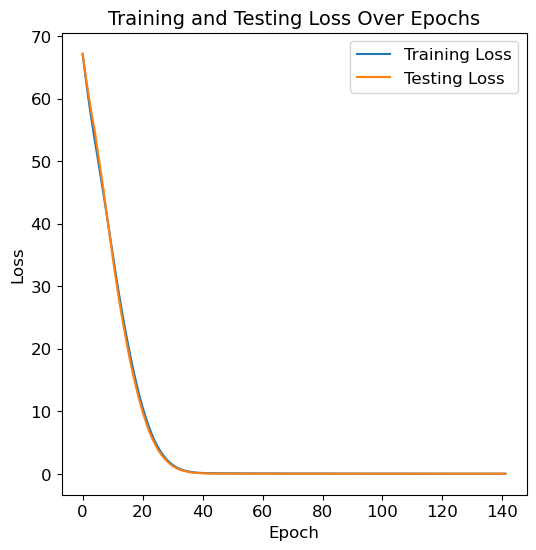

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

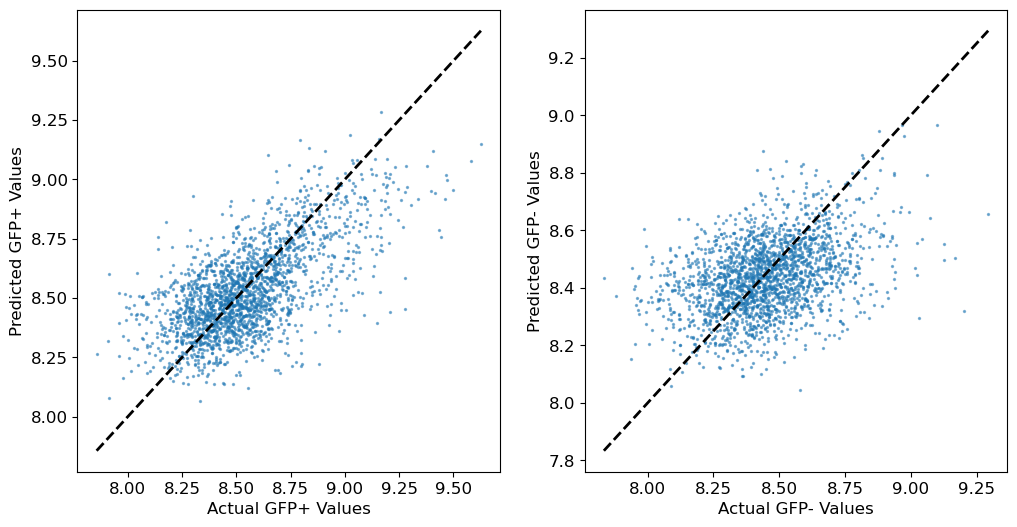

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

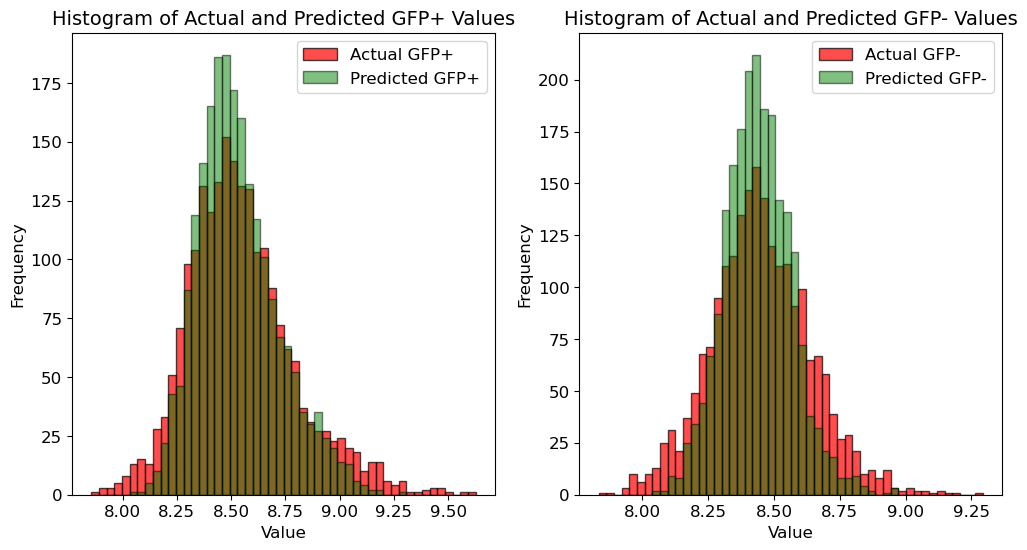

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

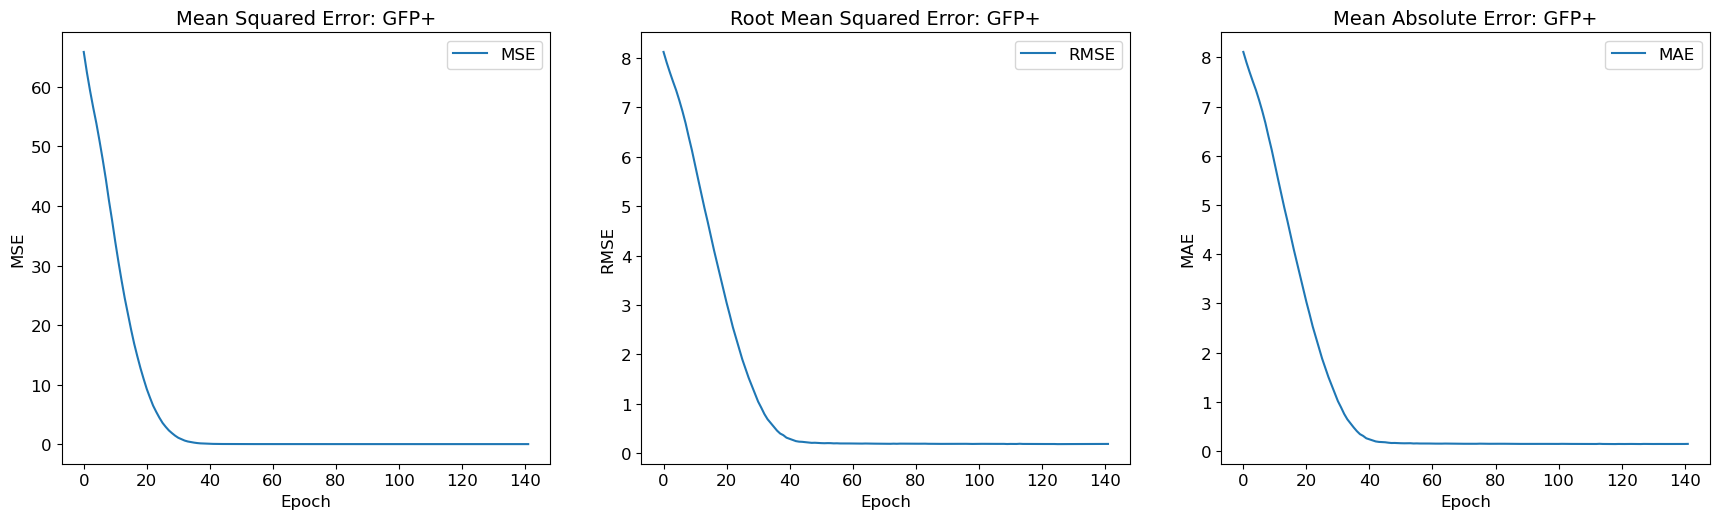

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

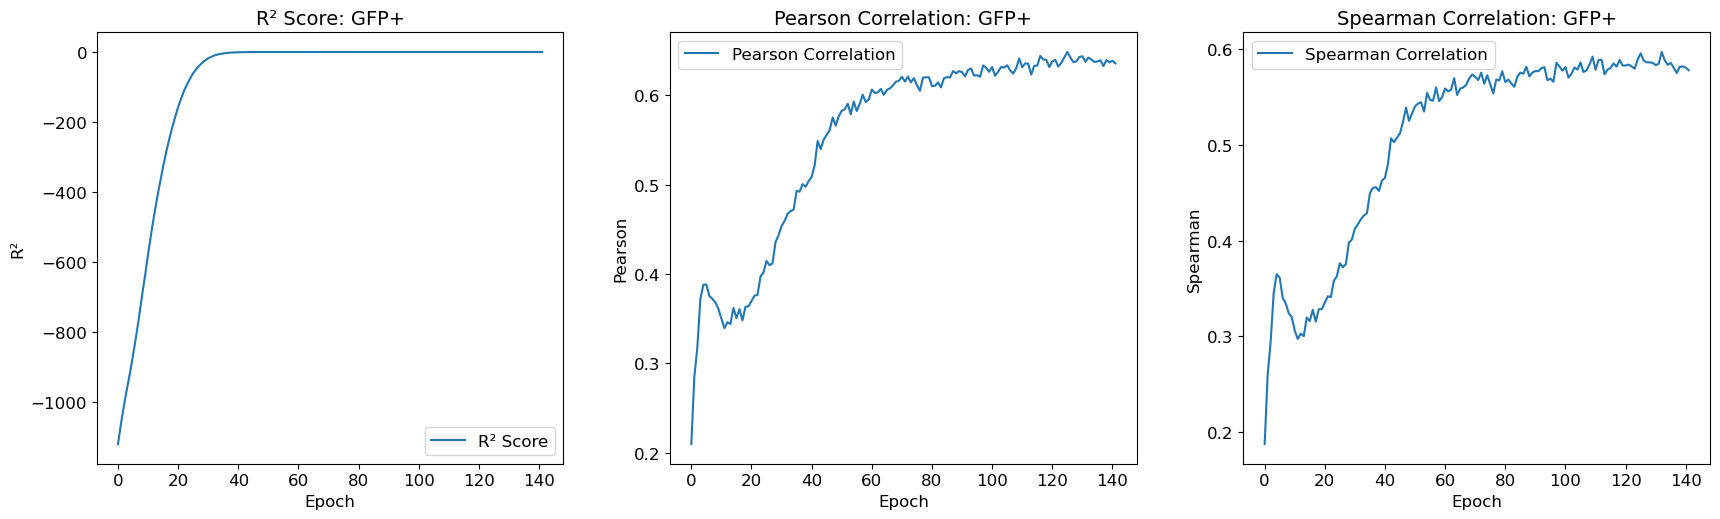

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

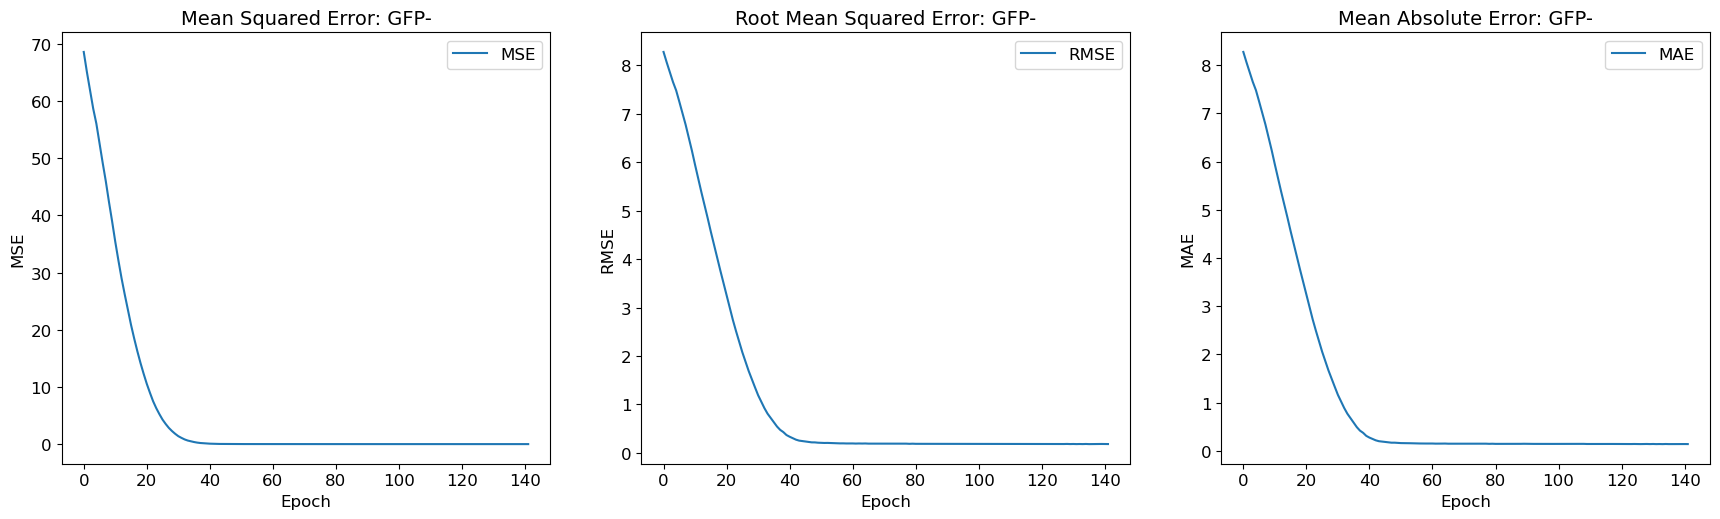

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

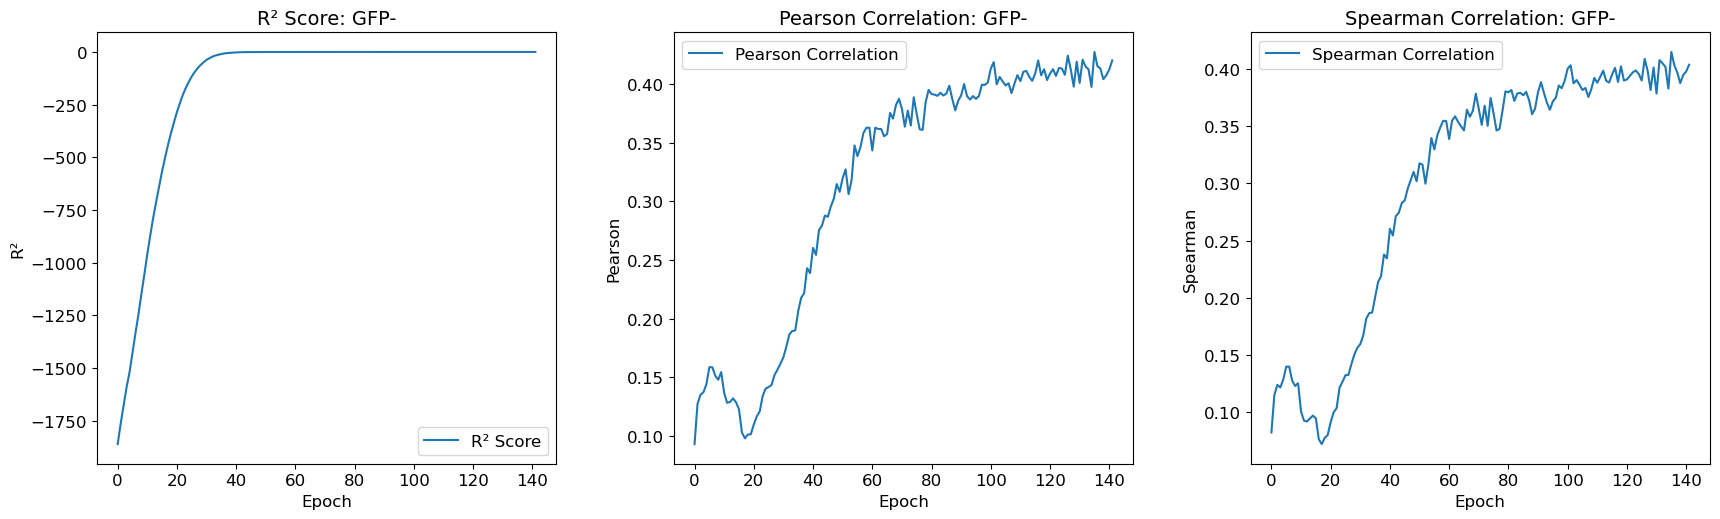

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

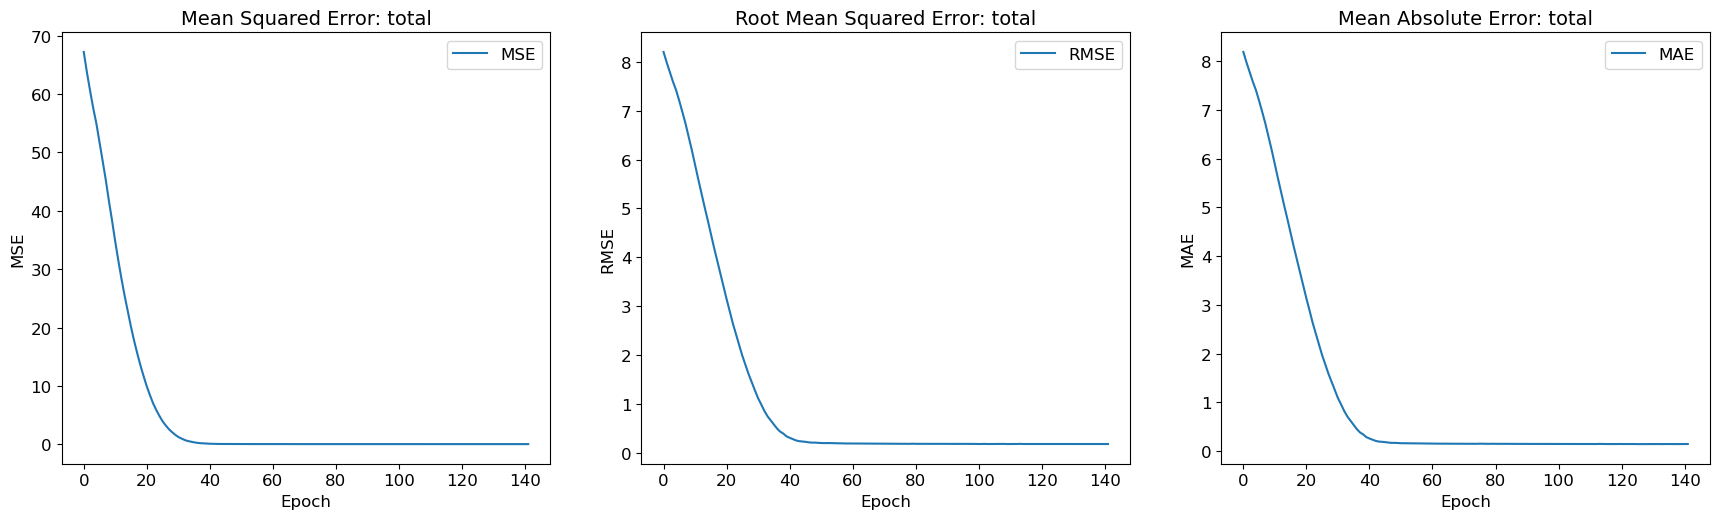

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

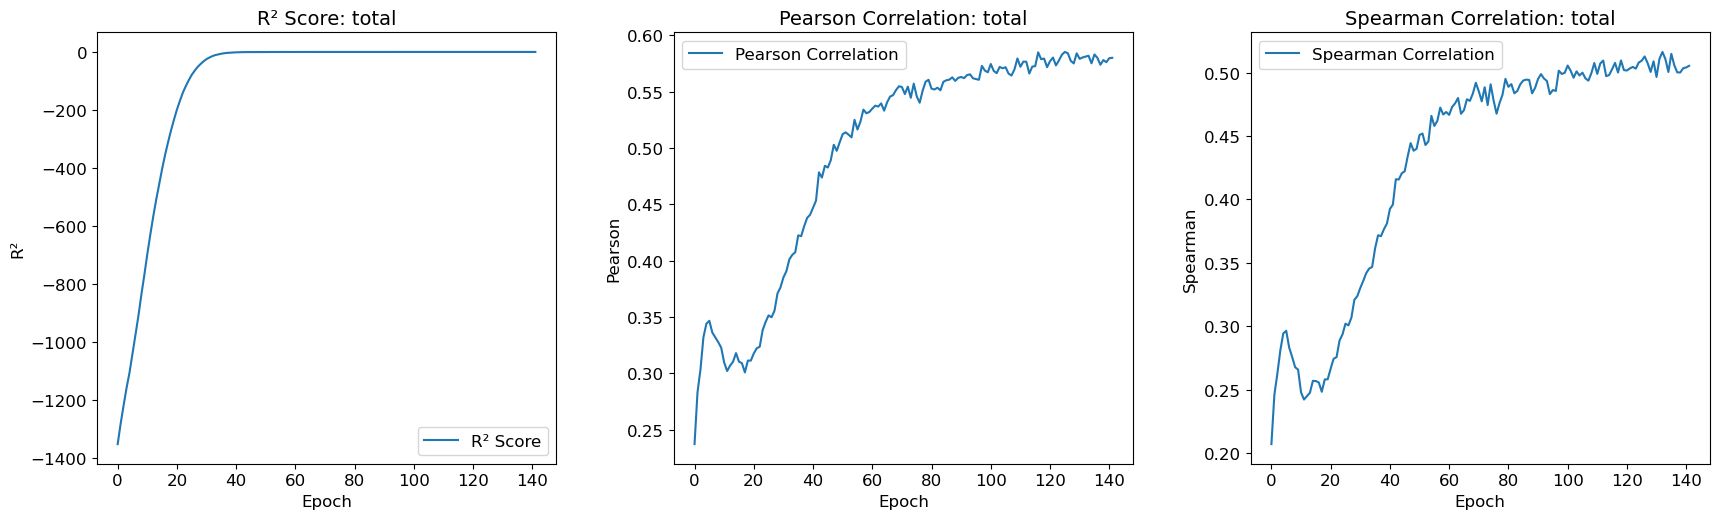

MSE: 0.0347, RMSE: 0.1862, MAE: 0.1444
R^2: 0.3024, Pearson Correlation: 0.5800, Spearman Correlation: 0.5054


In [7]:
model_path = glob.glob(f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred_70NN/best_pearson*.pth')[0]

mse, rmse, mae, r2, pearson_corr, spearman_corr = regression_model_plot(
    model, test_loader, train_losses_by_batch, test_losses_by_batch, 
    device, results, target_labels, save_plot = False, dir_path = None, model_path = model_path)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}")

### Interpret

In [5]:
import subprocess
import json

command = [
    "python", "Interpret.py", 
    "--num_class", "2", 
    "--seed", str(best_seed), 
    "--batch", str(best_batch), 
    "--num_cnns", str(num_cnns), 
    "--learning_rate", str(best_lr), 
    "--result_dir", output_dir,
    "--feature_list", json.dumps(['G+','G-']),  # Serialize list as JSON string
    "--target_labels", json.dumps(['GFP+','GFP-'])  # Serialize list as JSON string
]
#"--feature_list", json.dumps(['G+', 'G-']),  # Serialize list as JSON string
#"--target_labels", json.dumps(['GFP+', 'GFP-'])  # Serialize list as JSON string

# Run the command
result = subprocess.run(command, capture_output=True, text=True)

# Output the result
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)



STDOUT: Tomtom found at: /pmglocal/ty2514/meme/bin/tomtom
--------------------------------------------------------
***********************   1/8   ************************
--------------------------------------------------------
Attaching device to the gpu
Loading weight from following weight file to the model: 
['/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred/CNN10_Seed490/best_pearson_model_epoch_117.pth']




--------------------------------------------------------
***********************   2/8   ************************
--------------------------------------------------------
Reading input data for retreiving predictions
Get prediction using trained model!
Prediction shape is (14301, 2)


--------------------------------------------------------
***********************   3/8   ************************
--------------------------------------------------------
Now selecting high confident predictions!
Using Bound = 0.25 as a cutoff to select high confident predictions.
Tota

In [15]:
import os
for label in target_labels:
    tf_file = os.path.join(output_dir,'importance',label+'_sorted_tf_order.csv')
    tf_filters = pd.read_csv(tf_file)
    print(tf_filters.columns)

Index(['tf_name', 'importance_score'], dtype='object')
Index(['tf_name', 'importance_score'], dtype='object')


# Train multiple files

In [1]:
from torch.utils.data import DataLoader
from utils import split_dataset, train_model,EnhancerDatasetWithID
import pandas as pd
import glob

import sys
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import os
import subprocess
import json
import shutil
import random


sys.path.append('../model')  
from model import ConvNetDeep, DanQ, ExplaiNN,ConvNetDeep2, ExplaiNN2, ExplaiNN3,DeepSTARR

In [ ]:
list(range(80, 101, 5))
seeds = [223,276,291,832]

[80, 85, 90, 95, 100]

In [3]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN3_G+G-/ExplaiNN3_G+G-_Metrics.csv')
cnns = list(range(80, 101, 5))
target_labels = ["GFP+", "GFP-"]
feature_list = ["G+", "G-"]

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_input_data.csv')
# Data frame that stores the final results
final_data = {label: [] for label in target_labels}
seeds = [223,276,291,832]

# Loop over each CNN configuration
for cnn in cnns:
    
    temp_df = params[params['num_cnns'] == cnn]
    group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
    best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
    best_lr = best_group['lr']
    best_dropout = best_group['drop_out']
    best_batch = best_group['batch']

    best_group_df = temp_df[(temp_df['lr'] == best_lr) & (temp_df['drop_out'] == best_dropout) & (temp_df['batch'] == best_batch)]
    best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]
    best_seed = int(best_seed_row['seed'])
    best_batch = int(best_batch)

    num_cnns = cnn
    new_seeds = seeds + [best_seed]
    for seed in new_seeds:

        output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred/CNN{num_cnns}_Seed{seed}'

        print(f'\ncnn: {num_cnns}, lr: {best_lr}, drop_out: {best_dropout}, batch: {best_batch}, seed: {seed}\n')

        # Model Training
        batch = best_batch
        learning_rate = best_lr
        train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)
        
        train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode='none')
        test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode='none')
        validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode='none')

        train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
        test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
        val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)

        input_model = ExplaiNN3(num_cnns=num_cnns, input_length=608, num_classes=2, filter_size=19, num_fc=2, pool_size=7, pool_stride=7, drop_out=0.3, weight_path=None)
        _, _, model, *_ = train_model(input_model, train_loader, val_loader, test_loader, target_labels=target_labels, num_epochs=200, batch_size=batch, learning_rate=learning_rate, criteria='mse', optimizer_type="adam", patience=15, seed=seed, save_model=True, dir_path=output_dir)

        # Model Interpreting
        command = [
            "python", "Interpret.py", 
            "--num_class", "2", 
            "--seed", str(seed), 
            "--batch", str(best_batch), 
            "--num_cnns", str(num_cnns), 
            "--learning_rate", str(best_lr), 
            "--result_dir", output_dir,
            "--feature_list", json.dumps(['G+', 'G-']),  
            "--target_labels", json.dumps(['GFP+', 'GFP-']) 
        ]
        result = subprocess.run(command, capture_output=True, text=True)
        print("STDERR:", result.stderr)

        # Saving Results
        for label in target_labels:
            tf_file = os.path.join(output_dir, 'importance', f'{label}_sorted_tf_order.csv')
            if os.path.exists(tf_file):
                tf_filters = pd.read_csv(tf_file)
                tf_filters = tf_filters.iloc[:,:10]

                tf_names = tf_filters['tf_name'].tolist()
                importance_scores = tf_filters['importance_score'].tolist()
                row_data = {'num_cnn': num_cnns, 'seed': seed}
                for i in range(10):
                    row_data[f'tf{i+1}'] = tf_names[i]
                    row_data[f'score{i+1}'] = importance_scores[i]
                final_data[label].append(row_data)

        # Cleanup step to retain only CSV files (tf_files) and delete all other files, including .pth model files
        for item in os.listdir(output_dir):
            item_path = os.path.join(output_dir, item)
            
            # If the item is a file and not a CSV, delete it
            if os.path.isfile(item_path) and not item_path.endswith('.csv'):
                os.remove(item_path)
            
            # If the item is a directory
            elif os.path.isdir(item_path):
                if item == 'importance':
                    # Move the CSV files from the 'importance' subdirectory to the main output_dir
                    for label in target_labels:
                        tf_file_path = os.path.join(item_path, f'{label}_sorted_tf_order.csv')
                        if os.path.exists(tf_file_path):
                            shutil.move(tf_file_path, output_dir)
                    # Remove the 'importance' subdirectory after moving CSV files
                    shutil.rmtree(item_path)
                else:
                    # Remove any other subdirectories entirely
                    shutil.rmtree(item_path)


# Convert each label's data list into a DataFrame and save as CSV
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Pred'
for label, data in final_data.items():
    label_df = pd.DataFrame(data)
    output_file = os.path.join(output_dir, f'{label}_combined_tf_importance.csv')
    label_df.to_csv(output_file, index=False)
    print(f"Saved combined TF importance data for {label} to {output_file}")


cnn: 80, lr: 0.0001, drop_out: 0.3, batch: 96, seed: 223

Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/105, Loss: 74.2896
Epoch 1/200 -- Train Loss: 70.9656 , Validation Loss: 68.8040
------------------------Evaluation------------------------
Label 1: MSE=66.7503, RMSE=8.1701, MAE=8.1650, R^2=-1090.0235, Pearson=0.2741, Spearman=0.2593
Label 2: MSE=70.9474, RMSE=8.4230, MAE=8.4186, R^2=-1823.2940, Pearson=0.1016, Spearman=0.1051
Overall (Flattened): MSE=68.8488, RMSE=8.2975, MAE=8.2918, R^2=-1315.1973, Pearson=0.2838, Spearman=0.2581
----------------------------------------------------------
Epoch 2/200, Step 1/105, Loss: 67.7139
Epoch 2/200 -- Train Loss: 64.1818 , Validation Loss: 63.1548
------------------------Evaluation------------------------
Label 1: MSE=61.0589, RMSE=7.8140, MAE=7.8095, R^2=-996.9986, Pearson=0.3963, Spearman=0.3701
Label 2: MSE=65.3301, RMSE=8.0827, MAE=8.0784, R^2=-1678.8561, Pearson=0.1531, Spearman=0.1566
Overall (Flattened): MSE=63.19

In [ ]:
params = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN3_GFP/ExplaiNN3_GFP_Metrics.csv')
#cnns = list(range(10, 101, 5))
cnns = list(range(10, 101, 5))
target_labels = ["GFP"]
feature_list = ["GFP"]

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_input_data.csv')
# Data frame that stores the final results
final_data = {label: [] for label in target_labels}
#seeds = [random.randint(1, 1000) for _ in range(4)]
seeds = [463, 620, 820,930]

# Loop over each CNN configuration
for cnn in cnns:
    
    temp_df = params[params['num_cnns'] == cnn]
    group_means = temp_df.groupby(['lr', 'drop_out', 'batch'])['pearson_corr_p'].mean().reset_index()
    best_group = group_means.loc[group_means['pearson_corr_p'].idxmax()]
    best_lr = best_group['lr']
    best_dropout = best_group['drop_out']
    best_batch = best_group['batch']

    best_group_df = temp_df[(temp_df['lr'] == best_lr) & (temp_df['drop_out'] == best_dropout) & (temp_df['batch'] == best_batch)]
    best_seed_row = best_group_df.loc[best_group_df['pearson_corr_p'].idxmax()]
    best_seed = int(best_seed_row['seed'])
    best_batch = int(best_batch)

    num_cnns = cnn
    new_seeds = seeds + [best_seed]
    for seed in new_seeds:

        output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Pred/CNN{num_cnns}_Seed{seed}'

        print(f'\ncnn: {num_cnns}, lr: {best_lr}, drop_out: {best_dropout}, batch: {best_batch}, seed: {seed}\n')

        # Model Training
        batch = best_batch
        learning_rate = best_lr
        train_df, val_df, test_df = split_dataset(df, split_type='random', split_pattern=[0.7, 0.15, 0.15], seed=seed)
        
        train = EnhancerDatasetWithID(train_df, feature_list=feature_list, scale_mode='none')
        test = EnhancerDatasetWithID(test_df, feature_list=feature_list, scale_mode='none')
        validation = EnhancerDatasetWithID(val_df, feature_list=feature_list, scale_mode='none')

        train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
        test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
        val_loader = DataLoader(dataset=validation, batch_size=batch, shuffle=False)

        input_model = ExplaiNN3(num_cnns=num_cnns, input_length=608, num_classes=2, filter_size=19, num_fc=2, pool_size=7, pool_stride=7, drop_out=0.3, weight_path=None)
        _, _, model, *_ = train_model(input_model, train_loader, val_loader, test_loader, target_labels=target_labels, num_epochs=200, batch_size=batch, learning_rate=learning_rate, criteria='mse', optimizer_type="adam", patience=15, seed=seed, save_model=True, dir_path=output_dir)

        # Model Interpreting
        command = [
            "python", "Interpret.py", 
            "--num_class", "1", 
            "--seed", str(seed), 
            "--batch", str(best_batch), 
            "--num_cnns", str(num_cnns), 
            "--learning_rate", str(best_lr), 
            "--result_dir", output_dir,
            "--feature_list", json.dumps(['GFP']),  
            "--target_labels", json.dumps(['GFP']) 
        ]
        result = subprocess.run(command, capture_output=True, text=True)
        print("STDERR:", result.stderr)

        # Saving Results
        for label in target_labels:
            tf_file = os.path.join(output_dir, 'importance', f'{label}_sorted_tf_order.csv')
            print(f'tf file path is: {tf_file}')
            if os.path.exists(tf_file):
                tf_filters = pd.read_csv(tf_file)
                tf_filters = tf_filters.iloc[:,:10]


                tf_names = tf_filters['tf_name'].tolist()
                importance_scores = tf_filters['importance_score'].tolist()
                row_data = {'num_cnn': num_cnns, 'seed': seed}
                for i in range(10):
                    row_data[f'tf{i+1}'] = tf_names[i]
                    row_data[f'score{i+1}'] = importance_scores[i]
                final_data[label].append(row_data)

        # Cleanup step to retain only CSV files (tf_files) and delete all other files, including .pth model files
        for item in os.listdir(output_dir):
            item_path = os.path.join(output_dir, item)
            
            # If the item is a file and not a CSV, delete it
            if os.path.isfile(item_path) and not item_path.endswith('.csv'):
                os.remove(item_path)
            
            # If the item is a directory
            elif os.path.isdir(item_path):
                if item == 'importance':
                    # Move the CSV files from the 'importance' subdirectory to the main output_dir
                    for label in target_labels:
                        tf_file_path = os.path.join(item_path, f'{label}_sorted_tf_order.csv')
                        if os.path.exists(tf_file_path):
                            shutil.move(tf_file_path, output_dir)
                    # Remove the 'importance' subdirectory after moving CSV files
                    shutil.rmtree(item_path)
                else:
                    # Remove any other subdirectories entirely
                    shutil.rmtree(item_path)


# Convert each label's data list into a DataFrame and save as CSV
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Pred'
for label, data in final_data.items():
    label_df = pd.DataFrame(data)
    output_file = os.path.join(output_dir, f'{label}_combined_tf_importance.csv')
    label_df.to_csv(output_file, index=False)
    print(f"Saved combined TF importance data for {label} to {output_file}")


cnn: 10, lr: 0.0001, drop_out: 0.3, batch: 168, seed: 463

STDERR: 
100%|████████████████████| 71/71 [00:00<00:00, 192.49it/s]

100%|████████████████████| 10/10 [00:01<00:00,  6.49it/s]
Unable to create output directory '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_both_results/tomtom_results': No such file or directory.
FATAL: Unable to create output directory /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_both_results/tomtom_results.


tf file path is: /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_GFP_Pred/CNN10_Seed463/importance/GFP_sorted_tf_order.csv

cnn: 10, lr: 0.0001, drop_out: 0.3, batch: 168, seed: 620

STDERR: 
100%|████████████████████| 71/71 [00:00<00:00, 167.12it/s]

100%|████████████████████| 10/10 [00:01<00:00,  6.28it/s]
Unable to create output directory '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_both_results/tomtom_results': No such file or directory.
FATAL: Unable to create output directory /pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_both_resu

KeyboardInterrupt: 